# Report04 - Nathan Yee

This notebook contains report04 for computational baysian statistics fall 2016

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalNormalPdf
import thinkplot

import matplotlib.pyplot as plt
import pandas as pd

## Parking meter theft

From DASL(http://lib.stat.cmu.edu/DASL/Datafiles/brinkdat.html)

>The variable CON in the datafile Parking Meter Theft represents monthly parking meter collections by the principle contractor in New York City from May 1977 to March 1981. In addition to contractor collections, the city made collections from a number of "control" meters close to City Hall. These are recorded under the varia- ble CITY. From May 1978 to April 1980 the contractor was Brink's. In 1983 the city presented evidence in court that Brink's employees has been stealing parking meter moneys - delivering to the city less than the total collections. The court was satisfied that theft has taken place, but the actual amount of shortage was in question. Assume that there was no theft before or after Brink's tenure and estimate the monthly short- age and its 95% confidence limits.

So we are asking two questions. What is the probability that that money has been stolen? And how much money was stolen?

This problem is similar to that of "Improving Reading Ability" by Allen Downey

This is a repeat problem from last report but I've spend a couple of hours revising my calculations, improving explanation, and cleaning up rushed code.

To do this, we will use a series of distributions and see which are most likely based on the parking meter data. To start, we load our data from the csv file.

In [2]:
df = pd.read_csv('parking.csv', skiprows=17, delimiter='\t')
df.head()

,TIME,CON,CITY,BRINK
0,1,2224277,6729,0
1,2,1892672,5751,0
2,3,1468074,6711,0
3,4,1618966,7069,0
4,5,1509195,7134,0


Next, we need to normalize the CON (contractor) collections by the amount gathered by the CITY. This will give us a ratio of contractor collections to city collections.

In [3]:
df['RATIO'] = df['CON'] / df['CITY']

Next, lets see how the means of the RATIO data compare between the general contractors and BRINK.

In [4]:
grouped = df.groupby('BRINK')
for name, group in grouped:
    print(name, group.RATIO.mean())

0 244.681143201
1 229.583858011


We see that for every dollar gathered by the city, general contractors report 244.7 dollars while BRINK only reports 229.6 dollars.

To further investigate the differences between BRINK and general contractors, we will use bayesian statistics to see what values of `mu` and `sigma` of normal distributions fit our data. So, we create a class that accepts `mu's` and `sigmas's`. The likelihhod function allows us to iterate over our hypotheses and see which values of `mu` and `sigma` are most likely.

In [5]:
from scipy.stats import norm

class Normal(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        Computes the likelihood of a pair of mu and sigma given data. In this case, our
        data consists the ratios of contractor collections to city collections.
        
        Args:
            data: sequence of ratios of contractor collections to city collections.
            hypo: mu, sigma
            
        Returns:
            The likelihood of the data under the paricular mu and sigma
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma)
        return np.prod(likes)

Now, we want to calculate the marginal distribution of `mu` for the general contractors and BRINK. We can determine a distribution of how much money was stolen by calculating the difference between these distributions.

First we will generate sequences of `mu's` and `sigmas`.

In [6]:
mus = np.linspace(210, 270, 301)
sigmas = np.linspace(10, 65, 301)

Next, create our hypotheses as pairs of these `mu's` and `sigmas`.

In [7]:
from itertools import product

general = Normal(product(mus, sigmas))
data = df[df.BRINK==0].RATIO
general.Update(data)

3.1085419397107893e-52

Next, we use a contour plot to make sure we have selected a proper range of `mu's` and `sigmas`.

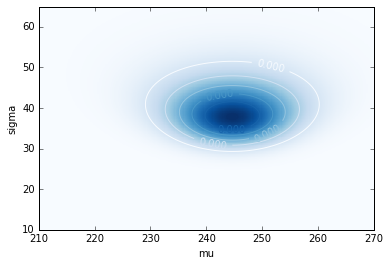

In [8]:
thinkplot.Contour(general, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

We see that our values of `mu` and `sigma` fit well within cutoff range.

Now, do the same for BRINK.

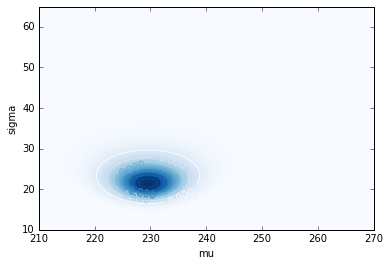

In [9]:
brink = Normal(product(mus, sigmas))
data = df[df.BRINK==1].RATIO
brink.Update(data)

thinkplot.Contour(brink, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

Finally, to get a distribution of possible ratio values, we extract the marginal distributions of `mu` from both the general contractors and BRINK.

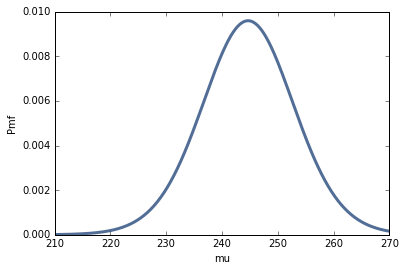

In [10]:
general_mu = general.Marginal(0)
thinkplot.Pdf(general_mu)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

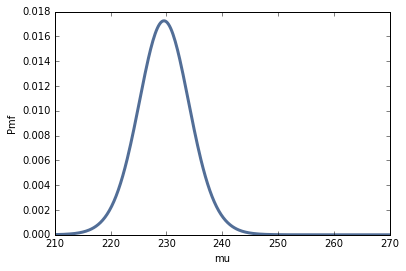

In [11]:
BRINK_mu = brink.Marginal(0)
thinkplot.Pdf(BRINK_mu)
thinkplot.Config(xlabel='mu', ylabel='Pmf')

To see how much money was stolen, we compute the difference of the marginal distributions. This immediately gives us difference of the means of the ratios as we could have calcuated earlier.

In [12]:
pmf_diff = BRINK_mu - general_mu
pmf_diff.Mean()

-15.022318455572226

To calculate the probability that money was stolen from the city, we simply look at a plot of the cdf of pmf_diff and see the probability that the difference is less than zero.

0.93875832542936855

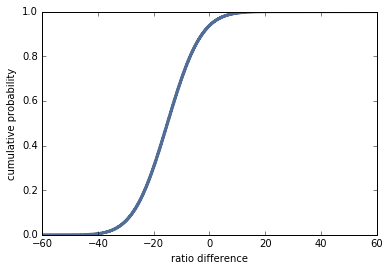

In [13]:
cdf_diff = pmf_diff.MakeCdf()
thinkplot.Cdf(cdf_diff)
thinkplot.Config(xlabel='ratio difference', ylabel='cumulative probability')
cdf_diff[0]

And we have answered the first question: the probability that money was stolen from the city is 93.9%

And lastly, we calculate how much money was stolen from the city. To do this, we first calculate how much money the city collected during (general or Brink) times. Then we can multiply this times our pmf_diff to get a probability distribution of potential stolen money.

(-3594455.9999999991, -1431125.9999999991)


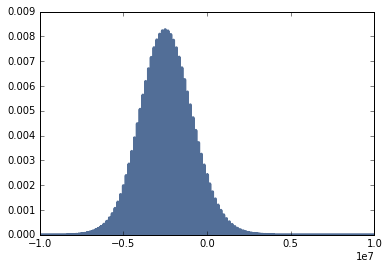

In [14]:
money_city = np.where(df['BRINK']==1, df['CITY'], 0).sum(0)
print((pmf_diff * money_city).CredibleInterval(50))
thinkplot.Pmf(pmf_diff * money_city)

Above we see a plot of stolen money in millions. We have also calculated a credible interval that tells us that there is a 50% chance that Brink stole between 1.4 to 3.6 million dollars. Interestingly, our distribution tells us that there is a probability that BRINK actually gave the city money. However, this is extremely unlikely and is an artifact of our normal distribution.

# How good is that cereal?
http://lib.stat.cmu.edu/DASL/Datafiles/Cereals.html

In [28]:
df = pd.read_csv('cereal.csv', skiprows=0, delimiter='\t')
df = df[['name','calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'cups', 'rating']]
df.head()

,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,cups,rating
0,100%_Bran,70,4,1,130,10,5,6,280,0.33,68.402973
1,100%_Natural_Bran,120,3,5,15,2,8,8,135,1.00,33.983679
2,All-Bran,70,4,1,260,9,7,5,320,0.33,59.425505
3,All-Bran_with_Extra_Fiber,50,4,0,140,14,8,0,330,0.50,93.704912
4,Almond_Delight,110,2,2,200,1,14,8,-1,0.75,34.384843


In [29]:
numerics = ['calories','protein','fat','sodium','fiber','carbo', 'sugars', 'potass', 'cups']

In [30]:
for column in numerics:
    df[column] = df[column] / df['cups']

In [31]:
df.head()

,name,calories,protein,fat,sodium,fiber,carbo,sugars,potass,cups,rating
0,100%_Bran,212.121212,12.121212,3.030303,393.939394,30.303030,15.151515,18.181818,848.484848,1,68.402973
1,100%_Natural_Bran,120.000000,3.000000,5.000000,15.000000,2.000000,8.000000,8.000000,135.000000,1,33.983679
2,All-Bran,212.121212,12.121212,3.030303,787.878788,27.272727,21.212121,15.151515,969.696970,1,59.425505
3,All-Bran_with_Extra_Fiber,100.000000,8.000000,0.000000,280.000000,28.000000,16.000000,0.000000,660.000000,1,93.704912
4,Almond_Delight,146.666667,2.666667,2.666667,266.666667,1.333333,18.666667,10.666667,-1.333333,1,34.384843


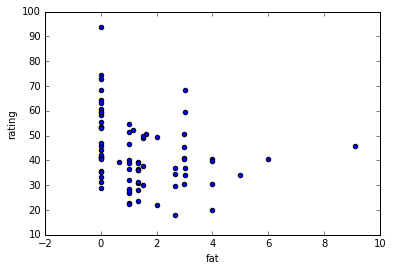

In [32]:
df.plot('fat', 'rating', kind='scatter')

# Smoking kills, analysis of smoking in different states

>The data are per capita numbers of cigarettes smoked (sold) by 43 states and the 
District of Columbia in 1960 together with death rates per thouusand population from
various forms of cancer.

Linear regression of number of cigarettes sold vs death by lung cancer

http://lib.stat.cmu.edu/DASL/Datafiles/cigcancerdat.html

In [2]:
df = pd.read_csv('smokingKills.csv', skiprows=21, delimiter='\t')
df.head()

,STATE,CIG,BLAD,LUNG,KID,LEUK
0,AL,18.20,2.90,17.05,1.59,6.15
1,AZ,25.82,3.52,19.80,2.75,6.61
2,AR,18.24,2.99,15.98,2.02,6.94
3,CA,28.60,4.46,22.07,2.66,7.06
4,CT,31.10,5.11,22.83,3.35,7.20


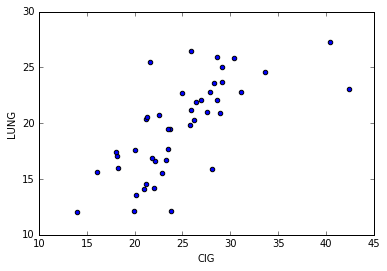

In [3]:
df.plot('CIG', 'LUNG', kind='scatter')

Abstract least squares function using a function

In [4]:
def leastSquares(x, y):
    """
    leastSquares takes in two arrays of values. Then it returns the slope and intercept
    of the least squares of the two.
    
    Args:
        x (numpy array): numpy array of values.
        y (numpy array): numpy array of values.
        
    Returns:
        slope, intercept (tuple): returns a tuple of floats.
    """
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y)[0]
    return slope, intercept

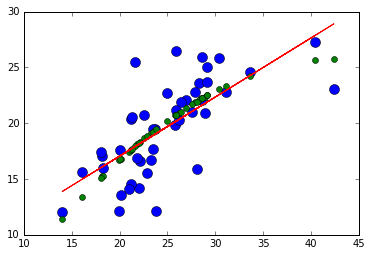

In [116]:
np.polyfit(cigs,lungs,2)

plt.plot(cigs, lungs, 'o', label='Original data', markersize=10)
plt.plot(cigs, -0.01714789 * cigs**2 + 1.47317813 * cigs - 5.88528037, 'o', label='Fitted line')
plt.plot(cigs, slope*cigs + intercept, 'r', label='Fitted line')
# plt.legend()
plt.show()

Create x and y vectors. x is the cig, y is the lung. Also create best fit line.

In [83]:
cigs = np.array(df['CIG'])
lungs = np.array(df['LUNG'])

slope, intercept = leastSquares(cigs, lungs)
print(slope, intercept)

0.529077926985 6.47168624727


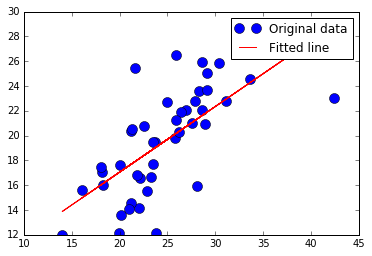

In [6]:
plt.plot(cigs, lungs, 'o', label='Original data', markersize=10)
plt.plot(cigs, slope*cigs + intercept, 'r', label='Fitted line')
plt.legend()
plt.show()

In [100]:
alphas = np.linspace(7.5, 8, 15)
betas = np.linspace(.4, .5, 15)
sigmas = np.linspace(4.5, 5.5, 15)

In [101]:
hypos = ((alpha, beta, sigma) for alpha in alphas 
         for beta in betas for sigma in sigmas)

data = [(cig, lung) for cig in cigs for lung in lungs]

In [102]:
class leastSquaresHypos(Suite, Joint):
    def Likelihood(self, data, hypo):
        """
        Likelihood calculates the probability of a particular line (hypo)
        based on data (ages Vs height) of our original dataset. This is
        done with a normal pmf as each hypo also contains a sigma.
        
        Args:
            data (tuple): tuple that contains ages (float), heights (float)
            hypo (tuple): intercept (float), slope (float), sigma (float)
            
        Returns:
            P(data|hypo)
        """
        intercept, slope, sigma = hypo
        total_likelihood = 1
        for cig, measured_lung in data:
            hypothesized_lung = slope * cig + intercept
            error = measured_lung - hypothesized_lung
            total_likelihood *= EvalNormalPdf(error, mu=0, sigma=sigma)
        return total_likelihood
        

In [103]:
LeastSquaresHypos = leastSquaresHypos(hypos)

In [104]:
for item in data:
    LeastSquaresHypos.Update([item])

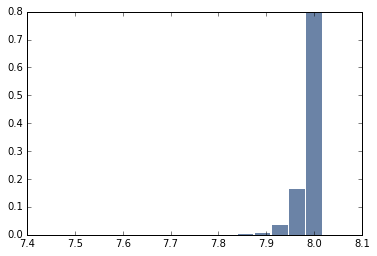

In [105]:
marginal_intercepts = LeastSquaresHypos.Marginal(0)
thinkplot.hist(marginal_intercepts)

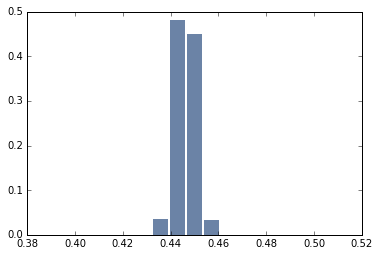

In [106]:
marginal_slopes = LeastSquaresHypos.Marginal(1)
thinkplot.hist(marginal_slopes)

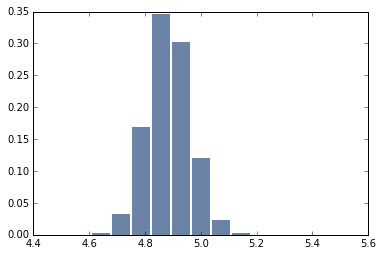

In [107]:
marginal_sigmas = LeastSquaresHypos.Marginal(2)
thinkplot.hist(marginal_sigmas)

In [81]:
len(cigs)

44

In [208]:
def getY(hypo_samples, random_x):
    """
    getY takes in random hypos and random x's and returns the coorisponding
    random height
    
    Args:
        hypo_samples
    """
    random_y = np.zeros(len(random_x))
    for i in range(len(random_x)):
        intercept = hypo_samples[i][0]
        slope = hypo_samples[i][1]
        sigma = hypo_samples[i][2]
        month = random_x[i]
        random_y[i] = np.random.normal((slope * month + intercept), sigma, 1)
    return random_y

def getRandomData(start, end, n, LeastSquaresHypos):
    """
    n - number of samples
    """
    random_hypos = LeastSquaresHypos.Sample(n)
    random_x = np.random.uniform(start, end, n)
    random_y = getY(random_hypos, random_x)
    return random_x, random_y

In [227]:
num_samples = 10000
random_cigs, random_lungs = getRandomData(14, 43, num_samples, LeastSquaresHypos)

In [233]:
def bucketData(num_buckets, x_range, y_range, x_data, y_data):
    """
    Computes the buckets and density of items of data for graphing pixel space
    
    Args:
        num_buckets (int): Is sqrt of number of buckets
        x_range (tuple): Contains floats for x_start and x_end
        y_range (tuple): Contains floats for y_start and y_end
        x_data (sequence): Random x data. Could be something like ages
        y_data (sequence): Random y data. Could be somethign like heights
        
    Returns:
        buckets (dict): Dictionary containing density of points.
    """
    x_start, x_end = x_range
    y_start, y_end = y_range

    # create horizontal and vertical linearly spaced ranges as buckets.
    hori_range, hori_step = np.linspace(x_start, x_end, num_buckets, retstep=True)
    vert_range, vert_step = np.linspace(y_start, y_end, num_buckets, retstep=True)

    hori_step = hori_step / 2
    vert_step = vert_step / 2

    # store each bucket as a tuple in a the buckets dictionary.
    buckets = dict()
    keys = [(hori, vert) for hori in hori_range for vert in vert_range]

    # set each bucket as empty
    for key in keys:
        buckets[key] = 0

    # loop through the randomly sampled data
    for x, y in zip(x_data, y_data):
        # check each bucket and see if randomly sampled data 
        for key in buckets:
            if x > key[0] - hori_step and x < key[0] + hori_step:
                if y > key[1] - vert_step and y < key[1] + vert_step:
                    buckets[key] += 1
                    break # can only fit in a single bucket
                    
    return(buckets)

In [234]:
buckets = bucketData(num_buckets=40, x_range=(14, 43), y_range=(-10, 50), x_data=random_cigs, y_data=random_lungs)

In [235]:
def unpackBuckets(buckets):
    """
    Unpacks buckets into three new ordered lists such that zip(xNew, yNew, zNew) would
    create x, y, z triples.
    """
    xNew = []
    yNew = []
    zNew = []
    for key in buckets:
        xNew.append(key[0])
        yNew.append(key[1])
        zNew.append(buckets[key]) 
        
    return xNew, yNew, zNew

In [236]:
cigsNew, lungsNew, intensities = unpackBuckets(buckets)

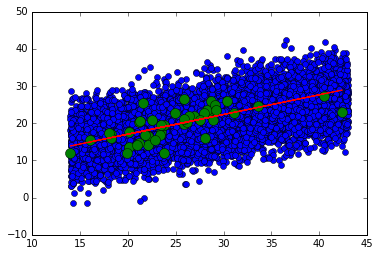

In [237]:
plt.plot(random_cigs, random_lungs, 'o', label='Random Sampling')
plt.plot(cigs, lungs, 'o', label='Original data', markersize=10)
plt.plot(cigs, slope*cigs + intercept, 'r', label='Fitted line')
# plt.legend()
plt.show()

In [238]:
def append_to_file(path, data):
    """
    append_to_file appends a line of data to specified file.  Then adds new line
    
    Args:
        path (string): the file path
    
    Return:
        VOID
    """
    with open(path, 'a') as file:
        file.write(data + '\n')
        
def delete_file_contents(path):
    """
    delete_file_contents deletes the contents of a file
    
    Args:
        path: (string): the file path
        
    Return:
        VOID
    """
    with open(path, 'w'):
        pass

def intensityCSV(x, y, z):
    file_name = 'cigsLungsIntensity.csv'
    delete_file_contents(file_name)

    for xi, yi, zi in zip(x, y, z):
        append_to_file(file_name, "{}, {}, {}".format(xi, yi, zi))
        
def monthHeightCSV(ages, heights):
    file_name = 'cigsLungs.csv'
    delete_file_contents(file_name)
    
    for month, height in zip(ages, heights):
        append_to_file(file_name, "{}, {}".format(month, height))
        
def fittedLineCSV(ages, slope, intercept):
    file_name = 'cigsLungsFitted.csv'
    delete_file_contents(file_name)
    for age in ages:
        append_to_file(file_name, "{}, {}".format(age, slope*age + intercept))
        
def makeCSVData(random_x, random_y, intensities, original_x, heights, slope, intercept):
    """
    Calls the 3 csv making functions with appropriate parameters.
    """
    intensityCSV(random_x, random_y, intensities)
    monthHeightCSV(original_x, heights)
    fittedLineCSV(original_x, slope, intercept)

In [239]:
makeCSVData(cigsNew, lungsNew, intensities, cigs, lungs, slope, intercept)

In [240]:
intensities

[0,
 0,
 28,
 16,
 0,
 27,
 1,
 4,
 0,
 0,
 24,
 1,
 0,
 0,
 12,
 12,
 0,
 0,
 20,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 33,
 0,
 36,
 0,
 0,
 33,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 30,
 27,
 33,
 4,
 3,
 21,
 0,
 19,
 0,
 0,
 1,
 0,
 0,
 7,
 0,
 3,
 28,
 13,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 6,
 32,
 0,
 0,
 0,
 10,
 12,
 21,
 0,
 0,
 0,
 25,
 0,
 28,
 3,
 13,
 0,
 0,
 1,
 31,
 27,
 0,
 2,
 0,
 0,
 0,
 0,
 12,
 22,
 0,
 0,
 0,
 0,
 3,
 17,
 0,
 33,
 0,
 2,
 12,
 1,
 4,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 15,
 0,
 0,
 21,
 27,
 0,
 6,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 25,
 4,
 0,
 0,
 0,
 0,
 42,
 0,
 0,
 6,
 0,
 0,
 39,
 0,
 26,
 0,
 0,
 11,
 8,
 0,
 1,
 0,
 0,
 32,
 0,
 0,
 0,
 2,
 1,
 0,
 9,
 3,
 23,
 0,
 0,
 13,
 0,
 20,
 13,
 0,
 0,
 4,
 17,
 0,
 26,
 0,
 12,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 22,
 20,
 0,
 0,
 15,
 0,
 0,
 11,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 15,
 0,
 22,
 29,
 11,
 2,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 0,
 11,
 0,
 36,
 17,
 23,
 0,
 31,
 1,
 0,

In [241]:
buckets

{(41.512820512820511, 13.076923076923077): 0,
 (23.666666666666668, -2.3076923076923075): 0,
 (25.897435897435898, 19.230769230769234): 28,
 (42.256410256410255, 33.07692307692308): 16,
 (27.384615384615387, 46.923076923076927): 0,
 (31.102564102564102, 23.846153846153847): 27,
 (15.487179487179487, 0.76923076923077005): 1,
 (21.435897435897438, 28.461538461538467): 4,
 (43.0, 45.384615384615387): 0,
 (31.846153846153847, 6.9230769230769234): 0,
 (17.717948717948719, 20.76923076923077): 24,
 (31.102564102564102, 34.61538461538462): 1,
 (42.256410256410255, -8.4615384615384617): 0,
 (18.46153846153846, -3.8461538461538458): 0,
 (42.256410256410255, 20.76923076923077): 12,
 (23.666666666666668, 26.923076923076927): 12,
 (17.717948717948719, -6.9230769230769234): 0,
 (29.615384615384617, 50.0): 0,
 (37.794871794871796, 19.230769230769234): 20,
 (34.820512820512818, 42.307692307692314): 0,
 (32.589743589743591, 2.3076923076923084): 0,
 (18.46153846153846, 45.384615384615387): 0,
 (38.53846

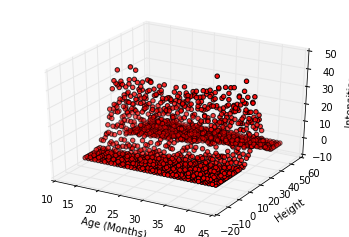

In [242]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = cigsNew
y = lungsNew
z = intensities



ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Age (Months)')
ax.set_ylabel('Height')
ax.set_zlabel('Intensities')

plt.show()